In [19]:
import numpy as np
from numpy import asarray
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline 

import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, experimental
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers


import import_ipynb
import sort_test_train_data
from sort_test_train_data import classes

In [20]:
#there is total 31 classes with 300-500 images
NUM_CLASSES = 31
classes_to_use = random.sample(classes, NUM_CLASSES)

In [21]:
#GLOBAL CONSTANTS
IMAGE_RESIZE = 1024
CROP_LENGTH = 448
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'

LOSS_METRICS = ['accuracy']

STEPS_PER_EPOCH_TRAINING = 10

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10

BATCH_SIZE = 100
BATCH_SIZE_TESTING = 1

In [22]:
#set model path
model_name = "Resnet50_" + str(NUM_EPOCHS) + "epochs_" + "1e^-5LR" + "_448CROP"
model_path = os.path.join(model_name)

In [26]:
#DEFINE MODEL
model = tf.keras.Sequential()

model.add(layers.experimental.preprocessing.RandomCrop(CROP_LENGTH, CROP_LENGTH))
# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained

model.layers[1].trainable = False

In [27]:
#get training data
train_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory = 'train/',
                                                    classes = classes_to_use,
                                                    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE)

Found 8219 images belonging to 31 classes.


In [28]:
sgd = optimizers.SGD(lr = 0.00001, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer= sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics= LOSS_METRICS)

In [29]:
fit_history = model.fit(train_generator, epochs = NUM_EPOCHS)

/usr/local/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/10
58/83 [===================>..........] - ETA: 10:45 - loss: 3.4344 - accuracy: 0.0340

/usr/local/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


83/83 [==============================] - 2152s 26s/step - loss: 3.4347 - accuracy: 0.0316
Epoch 2/10
83/83 [==============================] - 2151s 26s/step - loss: 3.4347 - accuracy: 0.0313
Epoch 3/10
83/83 [==============================] - 2246s 27s/step - loss: 3.4347 - accuracy: 0.0316
Epoch 4/10
83/83 [==============================] - 15897s 192s/step - loss: 3.4347 - accuracy: 0.0310
Epoch 5/10
83/83 [==============================] - 2583s 31s/step - loss: 3.4347 - accuracy: 0.0313
Epoch 6/10
83/83 [==============================] - 2396s 29s/step - loss: 3.4347 - accuracy: 0.0315
Epoch 7/10
83/83 [==============================] - 2286s 28s/step - loss: 3.4347 - accuracy: 0.0309
Epoch 8/10
83/83 [==============================] - 29102s 351s/step - loss: 3.4347 - accuracy: 0.0314
Epoch 9/10
83/83 [==============================] - 5031s 61s/step - loss: 3.4347 - accuracy: 0.0313
Epoch 10/10
83/83 [==============================] - 8829s 106s/step - loss: 3.4347 - accuracy: 0.

In [30]:
#save model 
model.save(model_path)

INFO:tensorflow:Assets written to: Resnet50_10epochs_1e^-5LR_CROP/assets


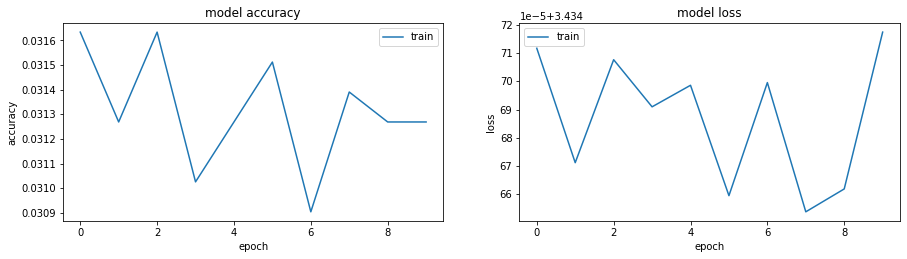

In [31]:
#plot loss and accuracy
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])    
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])    
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train']) 

plt.savefig(os.path.join(model_path, 'accuracy_loss.png'))
#plt.show()

In [32]:
test_generator = train_datagen.flow_from_directory(directory = 'test/',
                                                    classes = classes_to_use,
                                                    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE_TESTING)


Found 2851 images belonging to 31 classes.


In [33]:
test_loss, test_acc = model.evaluate(test_generator, batch_size = BATCH_SIZE_TESTING)

2851/2851 [==============================] - 1035s 363ms/step - loss: 3.4347 - accuracy: 0.0340


In [13]:
test_generator.reset()

pred = model.predict(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

2851/2851 [==============================] - 783s 275ms/step


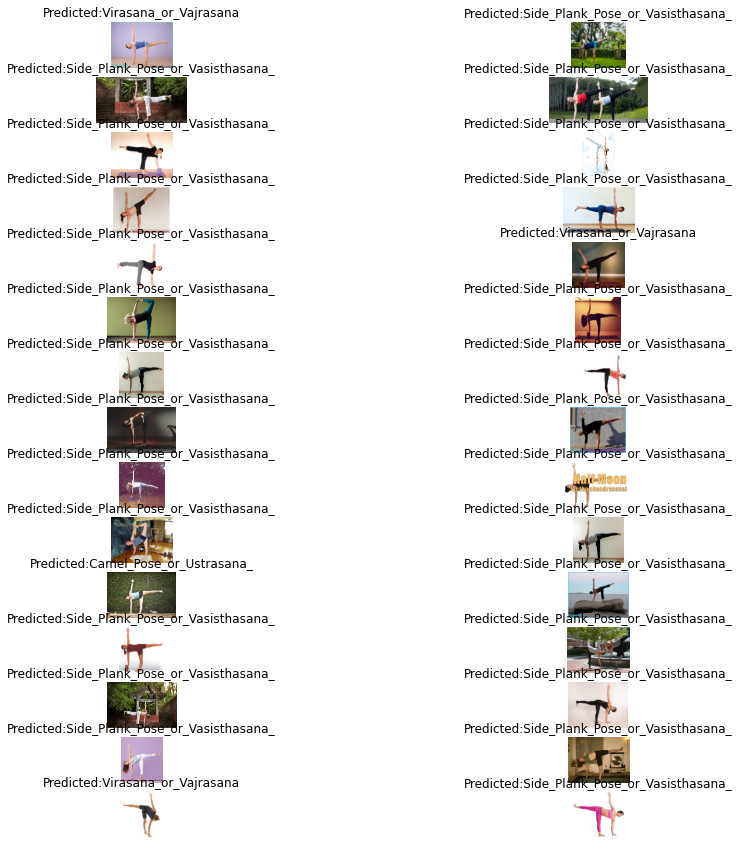

In [34]:
TEST_DIR = 'test/'
f, ax = plt.subplots(15, 2, figsize = (15, 15))

for i in range(0,30):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    predicted_class = classes_to_use[predicted_class_indices[i]]

    ax[i//2, i%2].imshow(imgRGB)
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title("Predicted:{}".format(predicted_class))    

plt.savefig(os.path.join(model_path, 'predictions.png'))
#plt.show()

In [18]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

print(results_df)

       id  label
0       1     27
1415    1      7
1414    1      7
1413    1      7
1412    1      7
...   ...    ...
867   672      7
868   673      7
2191  686      7
2192  687     14
869   694      7

[2851 rows x 2 columns]
